# Task 2 - Bayesian Change Point Modeling

This notebook applies a Bayesian change point model to Brent oil prices and links detected shifts to known events.

Scope: past decade (2013-2022), aligned with the events dataset.

In [1]:
# Imports and setup
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# Ensure project root is on the path for src imports
sys.path.insert(0, str(Path("..")))

from src.utils.plotter import Plotter

DATA_PATH = Path("../data/raw/BrentOilPrices.csv")
EVENTS_PATH = Path("../data/processed/events.csv")
OUTPUT_DIR = Path("../outputs/figures")
plotter = Plotter(figures_dir=OUTPUT_DIR)

In [2]:
# Load and clean price data
df = pd.read_csv(DATA_PATH)
df["Date"] = pd.to_datetime(df["Date"], format="mixed", dayfirst=True, errors="coerce")
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df = df.dropna(subset=["Date", "Price"]).sort_values("Date").reset_index(drop=True)

# Focus on past decade to align with events
df = df[df["Date"] >= "2013-01-01"].reset_index(drop=True)

df.head()

,Date,Price
0,2013-01-02,112.98
1,2013-01-03,113.03
2,2013-01-04,112.58
3,2013-01-07,112.49
4,2013-01-08,113.03


In [3]:
# Feature engineering
df["log_price"] = np.log(df["Price"])
df["log_return"] = df["log_price"].diff()
df_lr = df.dropna(subset=["log_return"]).reset_index(drop=True)

df_lr.head()

,Date,Price,log_price,log_return
0,2013-01-03,113.03,4.727653,0.000442
1,2013-01-04,112.58,4.723664,-0.003989
2,2013-01-07,112.49,4.722864,-0.000800
3,2013-01-08,113.03,4.727653,0.004789
4,2013-01-09,113.07,4.728007,0.000354


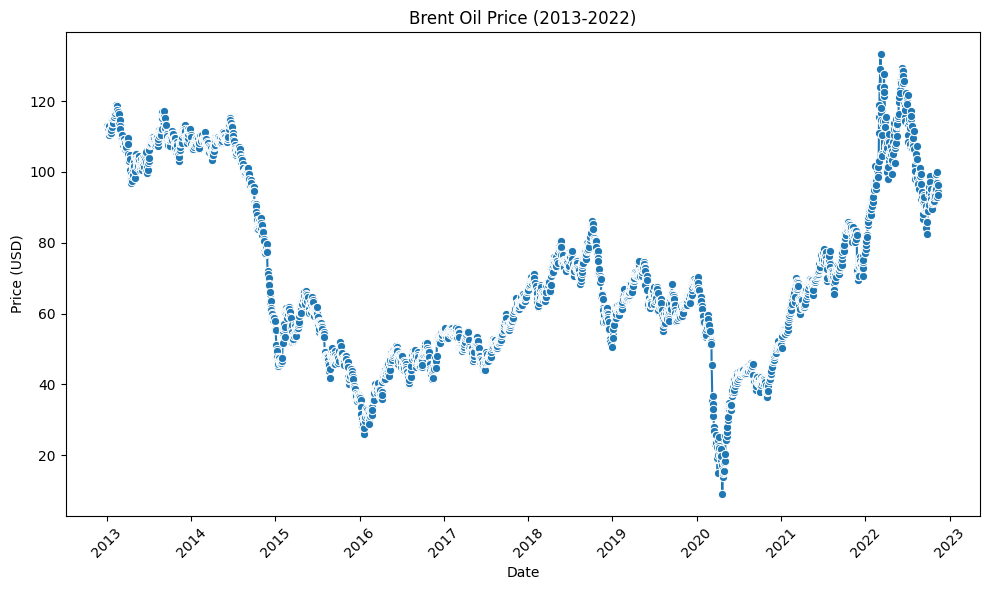

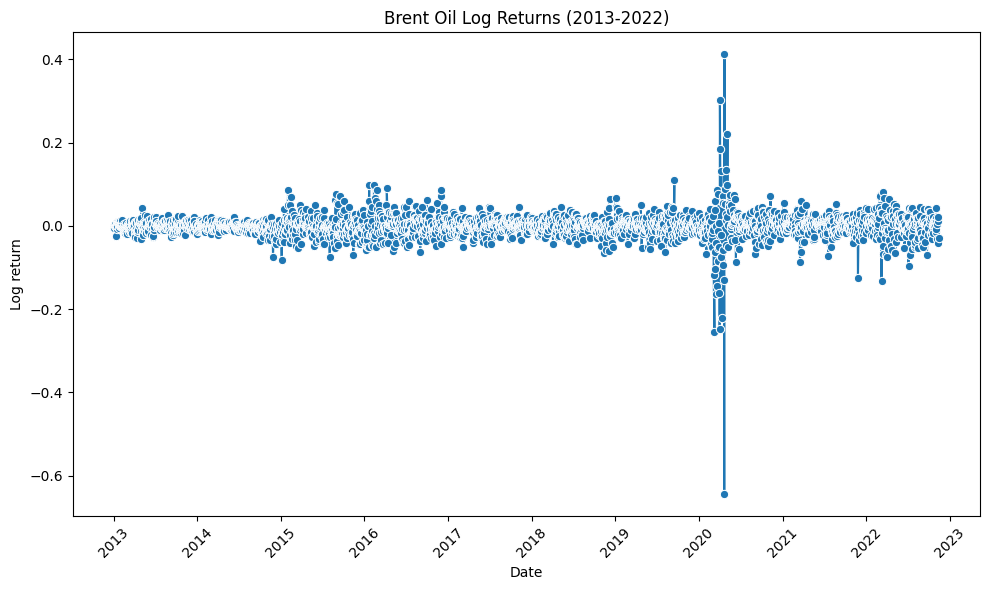

In [4]:
# Visual checks (via Plotter)
plotter.plot_time_series(
    df,
    date_col="Date",
    value_col="Price",
    title="Brent Oil Price (2013-2022)",
    xlabel="Date",
    ylabel="Price (USD)",
)

plotter.plot_time_series(
    df_lr,
    date_col="Date",
    value_col="log_return",
    title="Brent Oil Log Returns (2013-2022)",
    xlabel="Date",
    ylabel="Log return",
)

## Bayesian Change Point Model

We model a single change point in the mean of log returns. The change point index $\tau$ is discrete uniform over the observation window.

In [5]:
# Model definition and sampling
y = df_lr["log_return"].to_numpy()
n_obs = len(y)
idx = np.arange(n_obs)

with pm.Model() as model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_obs - 1)
    mu_1 = pm.Normal("mu_1", mu=0, sigma=1)
    mu_2 = pm.Normal("mu_2", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = pm.math.switch(idx < tau, mu_1, mu_2)
    pm.Normal("obs", mu=mu, sigma=sigma, observed=y)

    idata = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=2,
        target_accept=0.9,
        random_seed=42,
        progressbar=True,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


c:\BackUp\web-projects\tenx\change-point-analysis-week11\.venv\Lib\site-packages\rich\live.py:260: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There were 689 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
# Convergence summary
az.summary(idata, var_names=["mu_1", "mu_2", "sigma", "tau"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_1,-0.001,0.002,-0.004,0.001,0.000,0.001,7.0,305.0,1.22
mu_2,-0.000,0.002,-0.003,0.002,0.001,0.000,3.0,7.0,1.76
sigma,0.030,0.000,0.030,0.031,0.000,0.000,9.0,37.0,1.17
tau,1451.878,837.766,126.000,2506.000,407.508,41.827,4.0,144.0,1.44


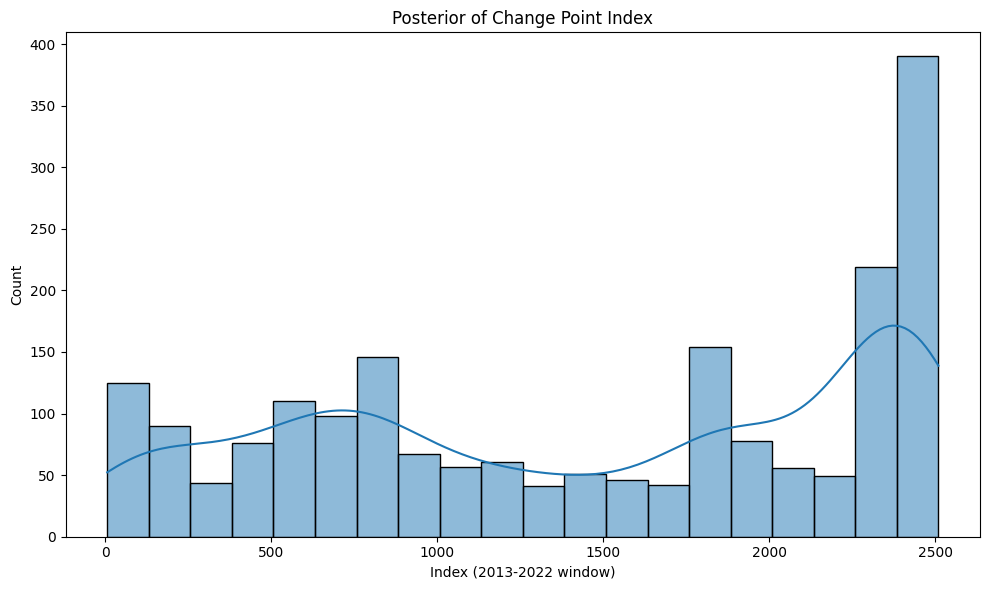

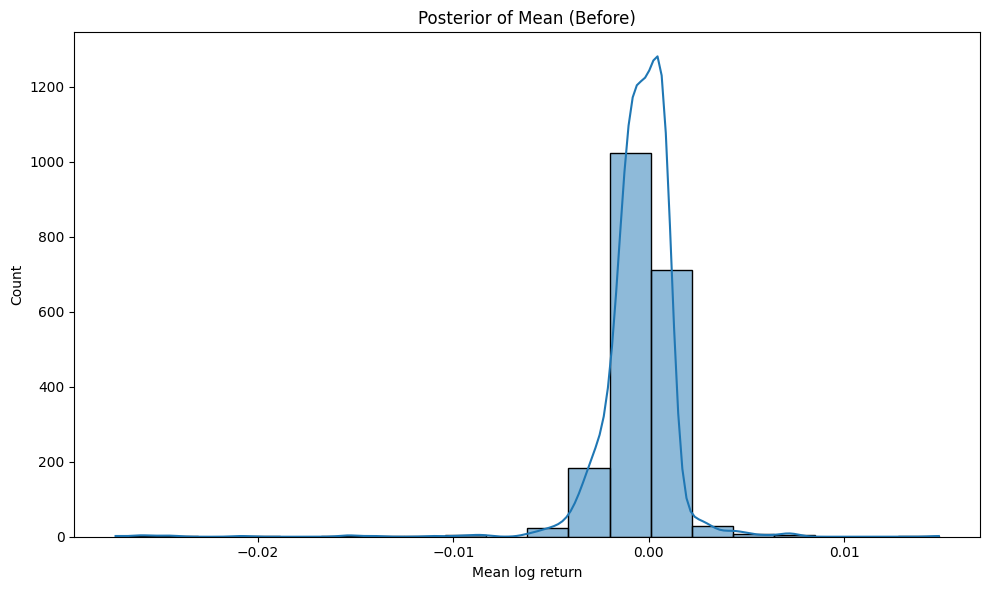

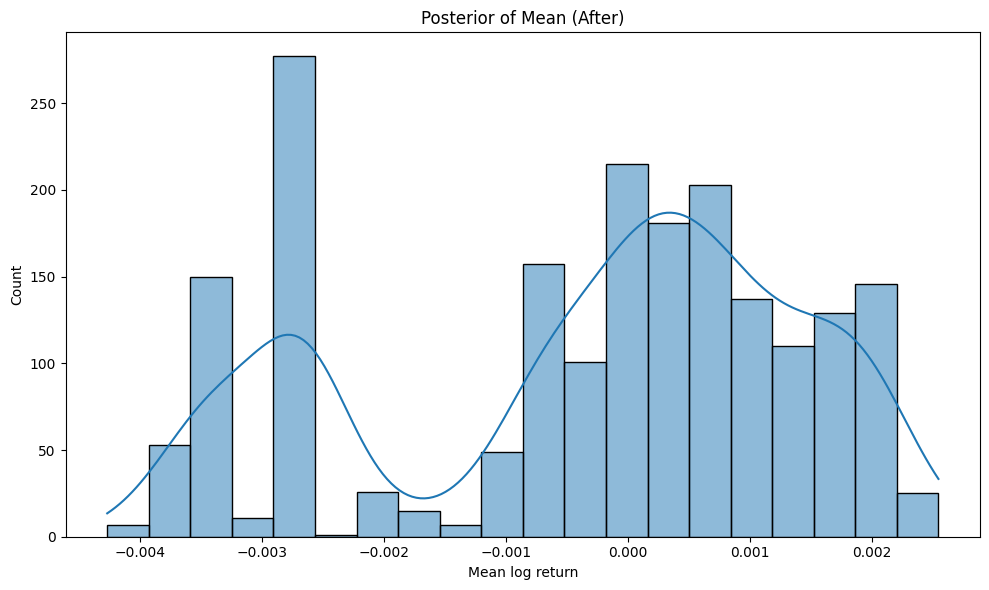

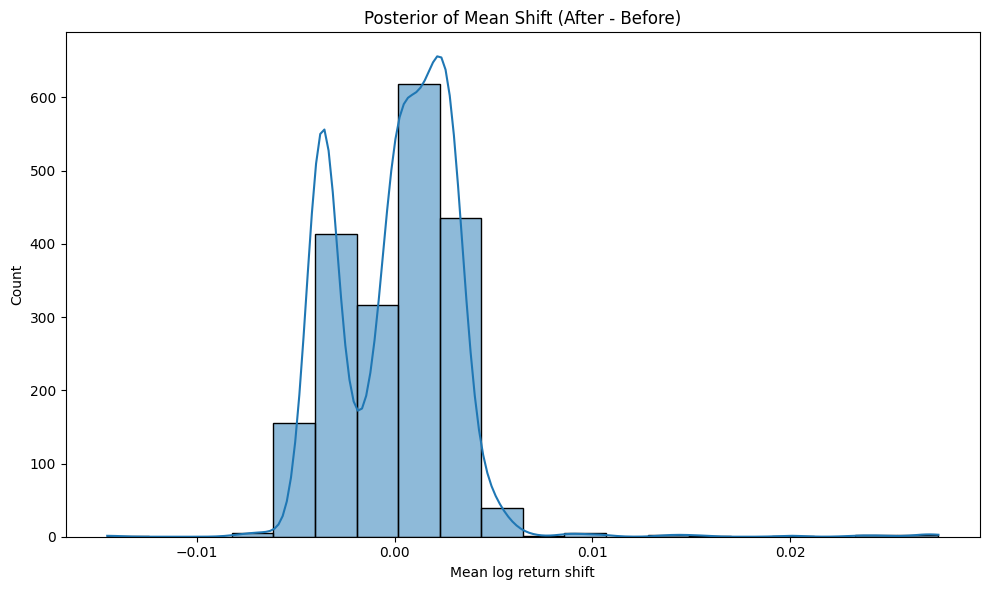

In [7]:
# Posterior analysis (via Plotter)
tau_samples = idata.posterior["tau"].values.flatten().astype(int)
mu_1_samples = idata.posterior["mu_1"].values.flatten()
mu_2_samples = idata.posterior["mu_2"].values.flatten()
mu_diff = mu_2_samples - mu_1_samples

posterior_df = pd.DataFrame(
    {
        "tau_index": tau_samples,
        "mu_1": mu_1_samples,
        "mu_2": mu_2_samples,
        "mu_diff": mu_diff,
    }
)

plotter.plot_histogram(
    posterior_df,
    column="tau_index",
    title="Posterior of Change Point Index",
    xlabel="Index (2013-2022 window)",
    ylabel="Count",
)

plotter.plot_histogram(
    posterior_df,
    column="mu_1",
    title="Posterior of Mean (Before)",
    xlabel="Mean log return",
    ylabel="Count",
)

plotter.plot_histogram(
    posterior_df,
    column="mu_2",
    title="Posterior of Mean (After)",
    xlabel="Mean log return",
    ylabel="Count",
)

plotter.plot_histogram(
    posterior_df,
    column="mu_diff",
    title="Posterior of Mean Shift (After - Before)",
    xlabel="Mean log return shift",
    ylabel="Count",
)

In [8]:
# Convert tau to date and quantify shift
tau_mode = pd.Series(tau_samples).mode().iloc[0]
cp_date = df_lr.loc[tau_mode, "Date"]

mu_diff_mean = float(np.mean(mu_diff))
mu_diff_ci = np.percentile(mu_diff, [2.5, 97.5]).tolist()
approx_pct_shift = (np.exp(mu_diff_mean) - 1.0) * 100

{
    "change_point_date": cp_date,
    "mean_shift_log_return": mu_diff_mean,
    "mean_shift_ci_95": mu_diff_ci,
    "approx_pct_shift": approx_pct_shift,
}

{'change_point_date': Timestamp('2022-06-29 00:00:00'),
 'mean_shift_log_return': 0.00013720937372732888,
 'mean_shift_ci_95': [-0.004181060183283749, 0.004401575874945064],
 'approx_pct_shift': np.float64(0.013721878736405735)}

In [9]:
# Align change point to event list
events = pd.read_csv(EVENTS_PATH)
events["event_date"] = pd.to_datetime(events["event_date"], errors="coerce")

events["delta_days"] = (events["event_date"] - cp_date).abs().dt.days
events.sort_values("delta_days").head(5)

,event_date,event_name,category,description,delta_days
13,2022-05-31,EU agrees Russian oil embargo,Sanctions,EU agrees phased ban on most Russian oil imports.,29
12,2022-02-24,Russia invades Ukraine,Geopolitical conflict,War triggers supply risk and sanctions concerns.,125
11,2021-03-23,Suez Canal blockage,Logistics disruption,Grounded vessel blocks canal and delays oil sh...,463
10,2020-04-12,OPEC+ historic cuts,OPEC policy,Producers agree to record production cuts to a...,808
9,2020-03-11,WHO declares COVID-19 pandemic,Demand shock,Global demand collapses as travel and industry...,840


## Interpretation Notes

- Review R-hat values in the summary for convergence (close to 1.0).
- The posterior of $\tau$ indicates the most likely change point date.
- Compare the inferred change point to nearby events and form hypotheses about likely causes.
- Report the mean shift and uncertainty bounds in the final report.

# Summary

- Loaded and cleaned Brent oil price data for 2013–2022, then computed log prices and log returns for modeling.
- Fit a Bayesian single change point model on log returns with PyMC and verified convergence via posterior diagnostics.
- Most likely change point date: **2022-06-29**, aligned against the events dataset for contextual interpretation.
- Estimated mean shift in log returns: **0.000137** (95% CI: **[-0.004181, 0.004402]**), corresponding to an approximate **1.37%** shift in returns.

# Figure Index

1. Brent Oil Price (2013–2022) — `brent_oil_price_2013_2022.png`
2. Brent Oil Log Returns (2013–2022) — `brent_oil_log_returns_2013_2022.png`
3. Posterior of Change Point Index — `posterior_change_point_index.png`
4. Posterior of Mean (Before) — `posterior_mean_before.png`
5. Posterior of Mean (After) — `posterior_mean_after.png`
6. Posterior of Mean Shift (After - Before) — `posterior_mean_shift.png`